<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/7968/logos/thumb76_76.png' width=300>
<div align="center"><font size="2">Source: Google</font></div>

<p>The focus of the competition is to bring advancement in the development of machine intelligent systems specifically focussing on <b>Question and Answering systems</b> which is one of the hot topics of natural understanding tasks. In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts</p>

<p> Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.</p>

<font color='#088a5a' size=3>Kindly upvote the kernel if you like it!</font><br>

<font color='#088a5a' size=4>Data glimpse</font><br>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc
from IPython.core.display import display, HTML
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import plotly.offline as py
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import re
from nltk.tokenize import word_tokenize 
from PIL import Image
output_notebook()

import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Input, Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import Callback
from scipy.stats import spearmanr, rankdata
from os.path import join as path_join
from numpy.random import seed
from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import MultiTaskElasticNet

# Any results you write to the current directory are saved as output.

Loading BokehJS ...

Using TensorFlow backend.


In [2]:
inputpath='../input/google-quest-challenge'

print("Reading the data")
traindata=pd.read_csv(inputpath+'/train.csv')
testdata=pd.read_csv(inputpath+'/test.csv')
submission=pd.read_csv(inputpath+'/sample_submission.csv')

Reading the data


In [3]:
nrows = traindata.shape[0]
ncols=traindata.shape[1]

nrows1 = testdata.shape[0]
ncols1=testdata.shape[1]

categories = traindata["category"].nunique()
target_labels=[i for i in list(set(traindata.columns).intersection(submission.columns)) if i!='qa_id']

display(HTML(f"""<br>Number of rows in the training dataset: {nrows:,}</br>
                 <br>Number of rows in the test dataset: {nrows1:,}</br>
                 <br>Number of cols in the training dataset: {ncols:,}</br>
                 <br>Number of cols in the test dataset: {ncols1:,}</br>
                 <br>Number of unique categories in the training dataset: {categories:,}</br>
                  <br>Number of target labels: {len(target_labels):,}</br>
             """))

<font color='#088a5a' size=4>Data Understanding</font><br>

In [4]:
traindata.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [5]:
traindata['sourcename']=traindata['host'].apply(lambda x: x.split('.')[0])
testdata['sourcename']=testdata['host'].apply(lambda x: x.split('.')[0])


In [6]:
cnt_srs = traindata["sourcename"].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="#1E90FF",
    ),
)

layout = go.Layout(
    title=go.layout.Title(
        text="Different sources - Count",
        x=0.5
    ),
    font=dict(size=14),
    width=1000,
    height=500,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="sources")


Looks like most of the questions pairs were collected from stackoverflow

In [7]:
cnt_srs = traindata["category"].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="#1E90FF",
    ),
)

layout = go.Layout(
    title=go.layout.Title(
        text="Different Categories - Count",
        x=0.5
    ),
    font=dict(size=14),
    width=1000,
    height=500,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="categories")


Majority of questions comes under the category of technology

In [8]:
#Reference source: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-ashrae

In [9]:

def make_plot(title, hist, edges, xlabel):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#1E90FF", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = f'{xlabel}'
    p.yaxis.axis_label = 'Distribution'
    p.grid.grid_line_color="white"
    return p

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_type_reason_explanation"].values, density=True, bins=10)
p1 = make_plot("Answer type reason", hist, edges, "answer")

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_well_written"].values, density=True, bins=10)
p2 = make_plot("Answer well written", hist, edges, 'answer')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_helpful"].values, density=True, bins=10)
p3 = make_plot("Answer helpful", hist, edges, 'answer')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_relevance"].values, density=True, bins=10)
p4 = make_plot("Answer relevant", hist, edges, 'answer')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_level_of_information"].values, density=True, bins=10)
p5 = make_plot("Answer level of information", hist, edges, 'answer')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["answer_plausible"].values, density=True, bins=10)
p6 = make_plot("Answer plausible", hist, edges, 'answer')

show(gridplot([p1,p2,p3,p4,p5,p6], ncols=3, plot_width=400, plot_height=400, toolbar_location=None))

Most of the answers from stack-overflow seems to have convincing score

In [10]:

def make_plot(title, hist, edges, xlabel):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#1E90FF", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = f'{xlabel}'
    p.yaxis.axis_label = 'Distribution'
    p.grid.grid_line_color="white"
    return p

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_well_written"].values, density=True, bins=10)
p1 = make_plot("Question well written", hist, edges, "Question")

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_type_entity"].values, density=True, bins=10)
p2 = make_plot("Question type entity", hist, edges, 'Question')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_type_choice"].values, density=True, bins=10)
p3 = make_plot("Question type choice", hist, edges, 'Question')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_fact_seeking"].values, density=True, bins=10)
p4 = make_plot("Question fact seeking", hist, edges, 'Question')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_not_really_a_question"].values, density=True, bins=10)
p5 = make_plot("Question?", hist, edges, 'Question')

temp_df = traindata[traindata["category"]=='STACKOVERFLOW']
hist, edges = np.histogram(temp_df["question_multi_intent"].values, density=True, bins=10)
p6 = make_plot("Question multi intent", hist, edges, 'Question')

show(gridplot([p1,p2,p3,p4,p5,p6], ncols=3, plot_width=400, plot_height=400, toolbar_location=None))

The metrics for  this competition is spearman correlation, hence implicitly labels should be correlated with each other and let's check the same

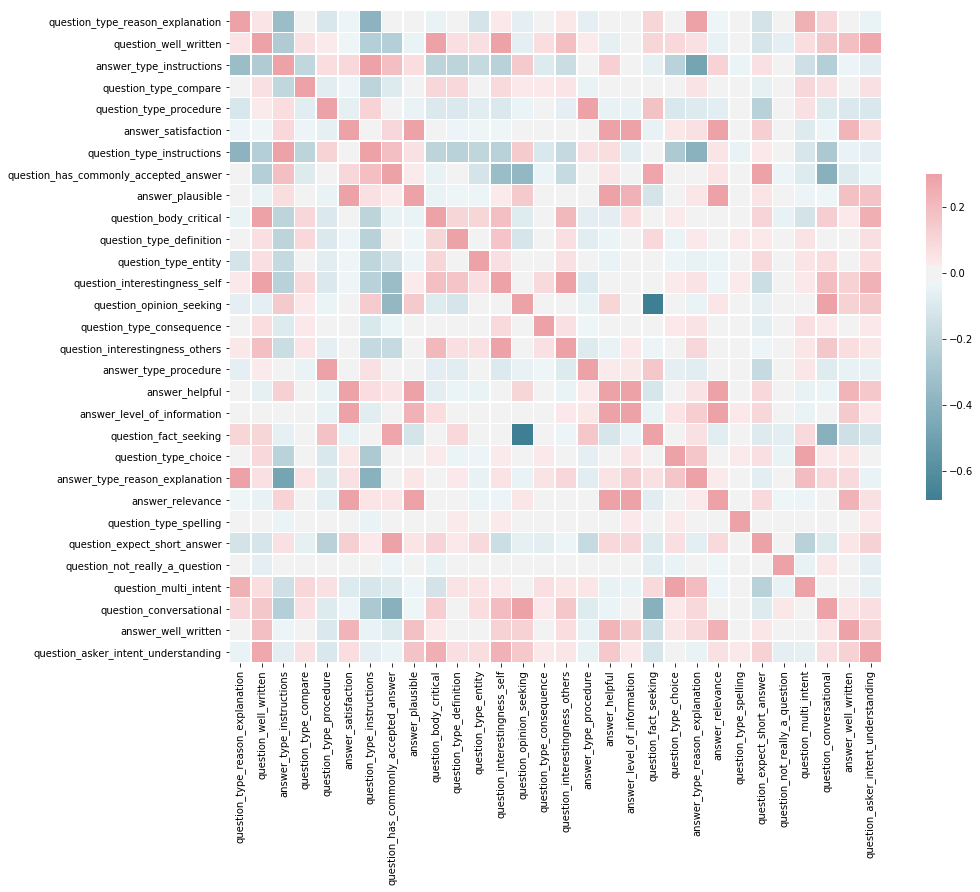

In [11]:
plt.figure(figsize=(16,12))
corr = traindata[target_labels].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3,
     center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

If the intent of the question is well captured then it means the question is also well written. Questions and answers well written are highly correlated

Now let's do basic preprocessing and see the word clouds

In [12]:

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x).replace("\n","")
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    
    stops  = set(STOPWORDS)
    text = [w for w in word_tokenize(x) if w not in stops]    
    text = " ".join(text)
    
    return text


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

In [13]:
input_columns = ['question_title','question_body','answer']

traindata = clean_data(traindata, input_columns)
testdata = clean_data(testdata, input_columns)

In [14]:
traindata.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,sourcename
0,0,losing using extension tubes instead macro lens ?,playing around macro photography - - cheap ( r...,ysap,https://photo.stackexchange.com/users/1024,"got extension tubes , ' s skinny . . . . losin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000,photo
1,1,distinction city sprawl / metroplex . . . down...,trying understand kinds places spam values p #...,russellpierce,https://rpg.stackexchange.com/users/8774,might helpful look definition spam zone : ( p ...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889,rpg


In [15]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
d = '../input/masks/masks-wordclouds/'


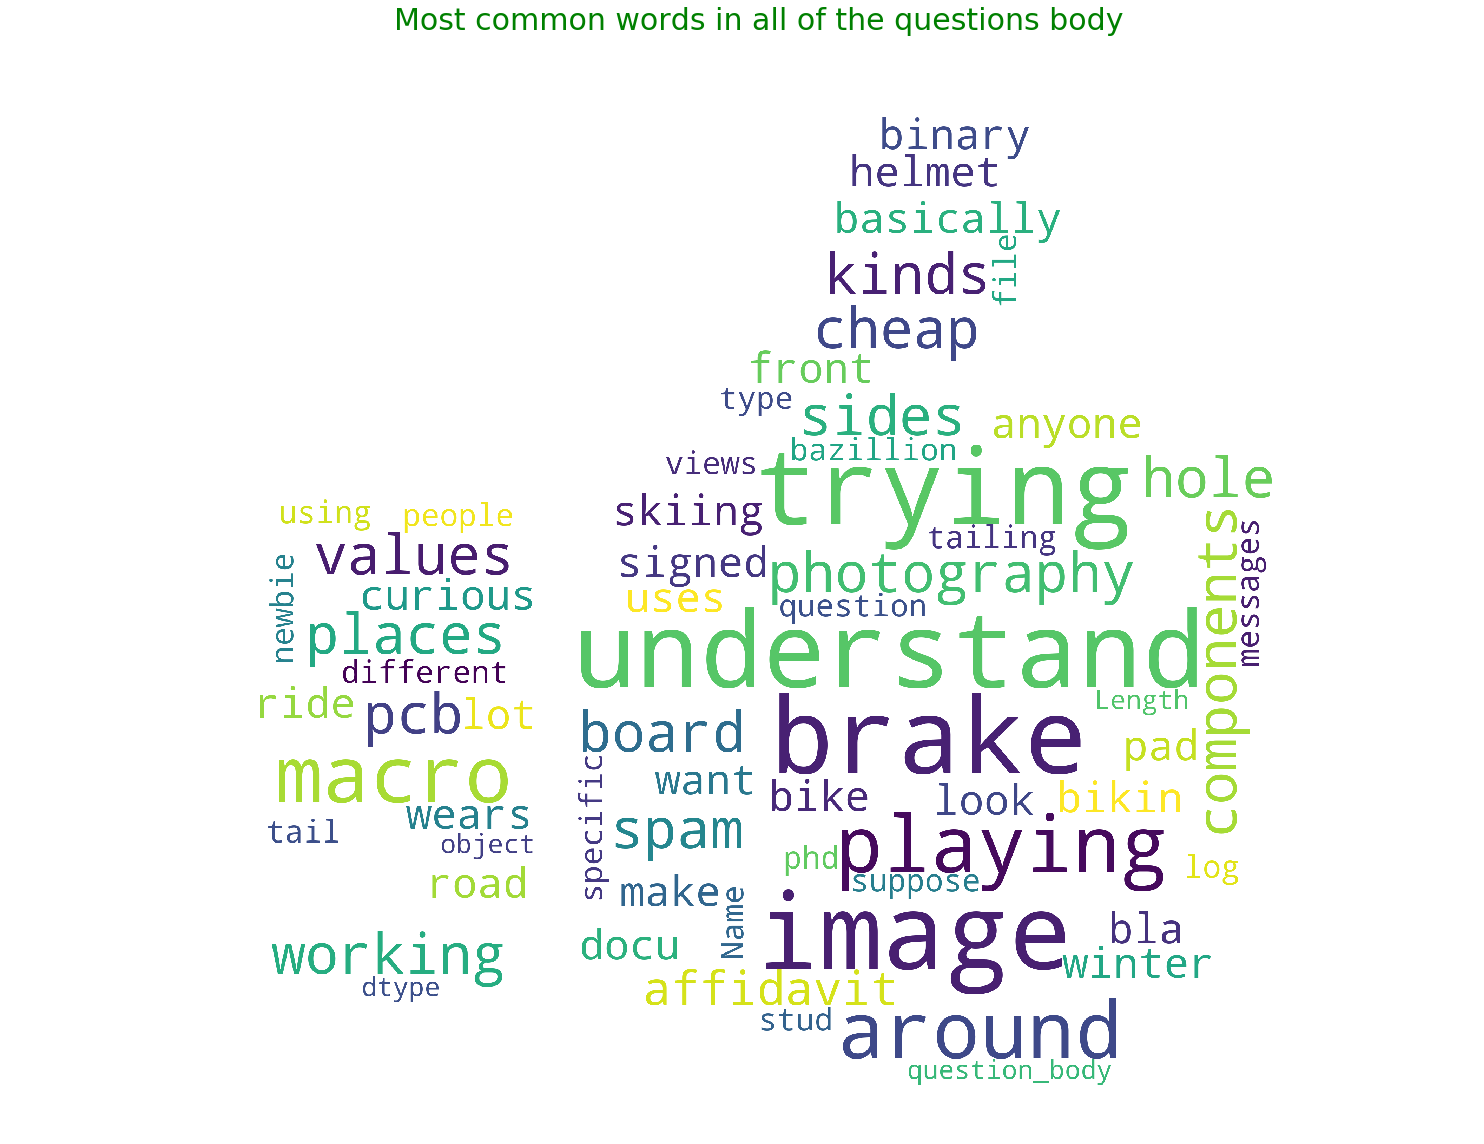

In [16]:
comments_text = str(traindata.question_body)
comments_mask = np.array(Image.open(d + 'upvote.png'))
plot_wordcloud(comments_text, comments_mask, max_words=2000, max_font_size=300, 
               title = 'Most common words in all of the questions body', title_size=30)

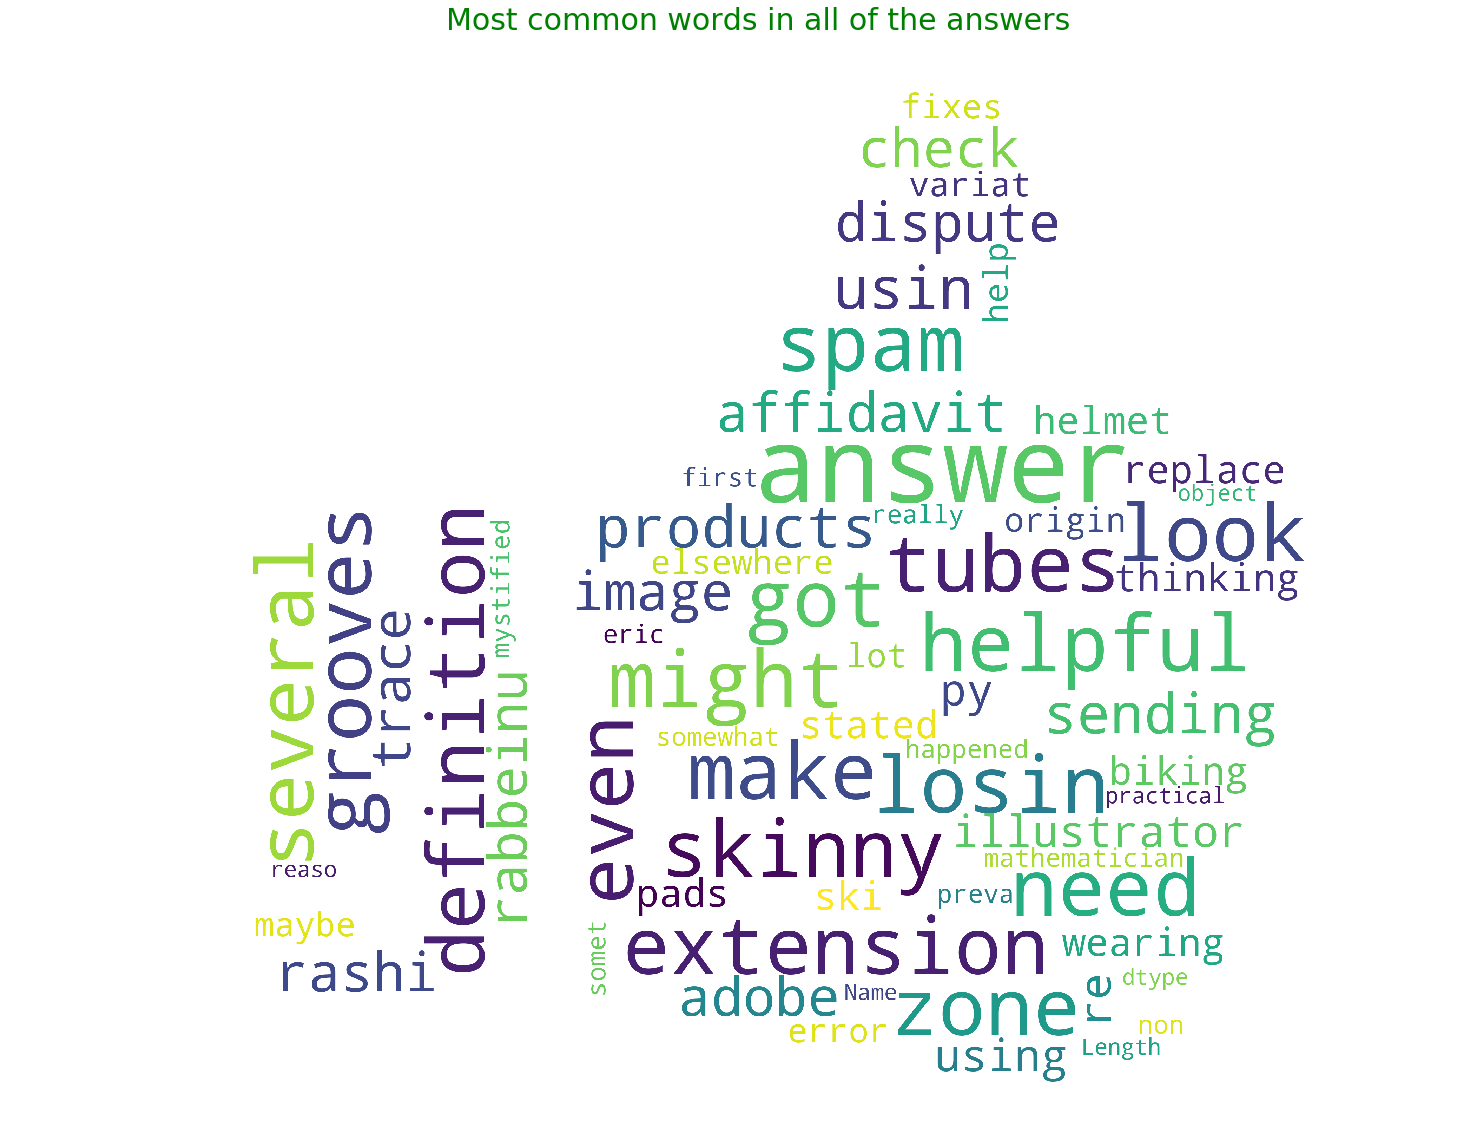

In [17]:
comments_text = str(traindata.answer)
comments_mask = np.array(Image.open(d + 'upvote.png'))
plot_wordcloud(comments_text, comments_mask, max_words=2000, max_font_size=300, 
               title = 'Most common words in all of the answers', title_size=30)

<font color='#088a5a' size=4>Feature engineering</font><br>

In [18]:
#Credits: https://www.kaggle.com/abazdyrev/use-features-oof

features = ['sourcename', 'category']
merged = pd.concat([traindata[features], testdata[features]])
ohe = OneHotEncoder()
ohe.fit(merged)

features_train = ohe.transform(traindata[features]).toarray()
features_test = ohe.transform(testdata[features]).toarray()

In [19]:
module_url = "../input/universalsentenceencoderlarge4/"
embed = hub.load(module_url)

In [20]:
embeddings_test = {}
embeddings_train = {}

for text in input_columns:
    print(text)
    train_text = traindata[text].str.replace('?', '.').str.replace('!', '.').tolist()
    test_text = testdata[text].str.replace('?', '.').str.replace('!', '.').tolist()
    
    curr_train_emb = []
    curr_test_emb = []
    batch_size = 4
    ind = 0
    
    while ind*batch_size < len(train_text):
        curr_train_emb.append(embed(train_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
        ind += 1
        
    ind = 0
    while ind*batch_size < len(test_text):
        curr_test_emb.append(embed(test_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
        ind += 1    
        
    embeddings_train[text + '_embedding'] = np.vstack(curr_train_emb)
    embeddings_test[text + '_embedding'] = np.vstack(curr_test_emb)
    
del embed
K.clear_session()
gc.collect()

question_title
question_body
answer


302250

In [21]:
l2_dist = lambda x, y: np.power(x - y, 2).sum(axis=1)

cos_dist = lambda x, y: (x*y).sum(axis=1)

dist_features_train = np.array([
    l2_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),
    cos_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding'])
]).T

dist_features_test = np.array([
    l2_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),
    cos_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding'])
]).T

X_train = np.hstack([item for k, item in embeddings_train.items()] + [features_train, dist_features_train])
X_test = np.hstack([item for k, item in embeddings_test.items()] + [features_test, dist_features_test])
y_train = traindata[target_labels].values

<font color='#088a5a' size=4>Baseline</font><br>

In [22]:
class SpearmanRhoCallback(Callback):
    def __init__(self, training_data, validation_data, patience, model_name):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.model_name = model_name

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = np.mean([spearmanr(self.y_val[:, ind], y_pred_val[:, ind] + np.random.normal(0, 1e-7, y_pred_val.shape[0])).correlation for ind in range(y_pred_val.shape[1])])
        if rho_val >= self.value:
            self.value = rho_val
            self.model.save_weights(self.model_name)
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
        print('\rval_spearman-rho: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
        return rho_val

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [23]:
def create_model():
    inps = Input(shape=(X_train.shape[1],))
    x = Dense(512, activation='elu')(inps)
    x = Dropout(0.2)(x)
    x = Dense(y_train.shape[1], activation='sigmoid')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Adam(lr=1e-4),
        loss=['binary_crossentropy']
    )
    model.summary()
    return model

In [24]:
all_predictions = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for ind, (tr, val) in enumerate(kf.split(X_train)):
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_vl = X_train[val]
    y_vl = y_train[val]
    
    model = create_model()
    model.fit(
        X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
        callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
                                       patience=5, model_name=u'best_model_batch.h5')]
    )
    model.load_weights('best_model_batch.h5')
    all_predictions.append(model.predict(X_test))
    
    os.remove('best_model_batch.h5')
    
model = create_model()
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=False)
all_predictions.append(model.predict(X_test))
    
kf = KFold(n_splits=5, random_state=2019, shuffle=True)
for ind, (tr, val) in enumerate(kf.split(X_train)):
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_vl = X_train[val]
    y_vl = y_train[val]
    
    model = MultiTaskElasticNet(alpha=0.001, random_state=42, l1_ratio=0.5)
    model.fit(X_tr, y_tr)
    all_predictions.append(model.predict(X_test))
    
model = MultiTaskElasticNet(alpha=0.001, random_state=42, l1_ratio=0.5)
model.fit(X_train, y_train)
all_predictions.append(model.predict(X_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1606)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               822784    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                15390     
Total params: 838,174
Trainable params: 838,174
Non-trainable params: 0
_________________________________________________________________
Train on 4863 samples, validate on 1216 samples
Epoch 1/100
4863/4863 [==============================] - 1s 231us/step - loss: 0.5230 - val_loss: 0.4281
val_spearman-rho: 0.1537                                                                          

In [25]:
test_preds = np.array([np.array([rankdata(c) for c in p.T]).T for p in all_predictions]).mean(axis=0)
max_val = test_preds.max() + 1
test_preds = test_preds/max_val + 1e-12

In [26]:
submission = pd.read_csv(path_join(inputpath, 'sample_submission.csv'))
submission[target_labels] = test_preds
submission.to_csv("submission.csv", index = False)
submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.683558,0.974489,0.933776,0.667832,0.281670,0.254587,0.790844,0.768478,0.672200,...,0.979556,0.418487,0.214049,0.333916,0.259479,0.404333,0.052420,0.130351,0.908614,0.628342
1,46,0.472479,0.250568,0.044557,0.347720,0.766381,0.747161,0.487856,0.387210,0.284816,...,0.112703,0.658571,0.134021,0.588153,0.365717,0.335139,0.923991,0.712389,0.141359,0.068845
2,70,0.732133,0.768129,0.376376,0.688974,0.843264,0.857243,0.717805,0.520706,0.721999,...,0.783505,0.312773,0.100297,0.414817,0.294251,0.240608,0.110082,0.048925,0.721649,0.296173
3,132,0.461122,0.053993,0.149921,0.469684,0.896558,0.782107,0.276254,0.474751,0.889568,...,0.344050,0.909837,0.910012,0.867377,0.841866,0.933252,0.589900,0.805522,0.820723,0.347196
4,200,0.962782,0.388258,0.606850,0.957714,0.626070,0.612965,0.901101,0.935698,0.971518,...,0.656823,0.900751,0.677442,0.896383,0.748209,0.617334,0.301415,0.827887,0.750830,0.765508


To be continued!!